In [1]:
# PROJECT 4 
    # E-commerce data: https://www.kaggle.com/carrie1/ecommerce-data 
        # 1. BASIC E-COMM INSIGHTS 
        # 2. DESCRIBE DATA 
        # 3. PLOT CLTV & REVENUE OVER TIME  
        # 4. IS CLTV PREDICTOR FOR REVENUE?  
        # 5. PREDICTION MODEL CLTV 
        # 6. PRODUCT CATEGORY: UNIT PRICE    

In [2]:
# Import Libraries

'''
L.S. First of all: Well done! This was a very interesting and well-excecuted project. You started off with a very clear
idea on how to approach this kind of question and, fortunatly, you found a corresponding data set that gave you some interesting,
albeit limited (due to the time span of the data) insights. The data exploration looks quite good and, I think, gave you some
valuable information regarding the scope and limitations of the data. The presentation was also very good! You presented nice plots
and were able to back-up your claims with statistical tests. The code quality is good as well. 
'''


import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import chart_studio.plotly as py
import cufflinks as cf
cf.go_offline()
from ipywidgets import interact
from scipy import stats 
import plotly.express as px
import plotly.graph_objs as go
import statsmodels.api as sm
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tools.eval_measures import rmse

In [3]:
# import data and encode 'cp1252'
data = pd.read_csv('data.csv', encoding='cp1252')
data.head() 

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
# DATA CLEANING

In [5]:
# I first checked the data with following code: 
    # data.describe() >> unusual descriptive statistics? 
    # data.dtypes >> are the types correct? 
    # data[data.isnull().any(axis=1)].shape[0] >> how many rows with missing values in it? 

# filtering out negative Quantity and UnitPrices 
data2 = data[(data.Quantity > 0) & (data.UnitPrice > 0)]

# filtering out rows with missing values 
data3 = data2.dropna()

# make CustomerID an object instead of float 
data3['CustomerID'] = data3['CustomerID'].astype(object) 

# filtered descriptions with ‘DOTCOM POSTAGE’ & 'POSTAGE' & 'Manual' out (outliers + no direct indicator of sales)
data4 = data3[(data3.Description != 'Manual') & (data3.Description != 'POSTAGE') 
                & (data3.Description !='DOTCOM POSTAGE')]

# filtered out 2 extreme outliers (Quantity > 7000) 
data4 = data4[data4['Quantity'] < 7000] 
data4.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [6]:
# 1. BASIC E-COMM INSIGHTS:
    # AVERAGE ORDER VALUE PER CUSTOMER 
    # AVERAGE PURCHASE FREQUENCY PER CUSTOMER 
    # AVERAGE RETURN RATE 
    # AVERAGE CHURN RATE 
    # AVERAGE CLTV (WITHOUT MARGIN) 
    # AVERAGE CLTV (WITH MARGIN) 

In [7]:
# select columns for calculations & change order
data5 = data4[['CustomerID', 'InvoiceNo', 'Quantity', 'UnitPrice']]

# change col names 
col_names = ['customer_id', 'order_id', 'quantity', 'unit_price']
data5.columns = col_names
data5.head()

# make column revenue 
data5['revenue'] = data5['quantity']*data5['unit_price'] 

# make df1: total orders per customer (hoeveel bestellingen)
df1 = pd.DataFrame(data5.groupby('customer_id')['order_id'].count())
colorder = ['orders']
df1.columns = colorder 

# make df2: total quantity per customer (hoeveel stuks)
df2 = pd.DataFrame(data5.groupby('customer_id')['quantity'].sum())

# make df3: total revenue per customer (opbrengst) 
df3 = pd.DataFrame(data5.groupby('customer_id')['revenue'].sum())

# merge all dataframes 
df4 = pd.concat([df1, df2, df3], axis=1)
df4.head() 

,orders,quantity,revenue
customer_id,,,
12347.0,182,2458,4310.00
12348.0,27,2332,1437.24
12349.0,72,630,1457.55
12350.0,16,196,294.40
12352.0,77,526,1385.74


In [8]:
# average order value: total revenue / total orders 
avg_order_value = df4['revenue'].sum() / df4['orders'].sum() 
print('the average order value is:', round(avg_order_value,2))

# average purchase frequency (average orders): mean orders 
avg_purchase_freq = df4['orders'].mean() 
print('\nthe average purchase frequency is:', round(avg_purchase_freq))

# average retrun_rate & churn rate
retrun_rate = df4[df4.orders>1].shape[0]  / df4['orders'].shape[0]
churn_rate = 1 - retrun_rate 
print('\nthe average return rate is:', round(retrun_rate,2), 'this means that', int(round(retrun_rate,2)*100), '% returns')
print('the average churn rate is:', round(churn_rate,2), 'this means that', int(round(churn_rate,2)*100), '% do not return')

# avg CLTV & avg CLTV marge (I took an average gross profit margin of 40%)
cltv_no_margin = (avg_order_value*avg_purchase_freq) / churn_rate
cltv_margin = cltv_no_margin*0.40 

print('\nthe average CLTV without taking into account the profit margin is:', round(cltv_no_margin,2)) 
print('the average CLTV taking into account an average profit margin of 40% is:', round(cltv_margin,2))

the average order value is: 21.49

the average purchase frequency is: 91

the average return rate is: 0.98 this means that 98 % returns
the average churn rate is: 0.02 this means that 2 % do not return

the average CLTV without taking into account the profit margin is: 118364.78
the average CLTV taking into account an average profit margin of 40% is: 47345.91


In [9]:
# DESCRIBE DATA 

In [10]:
# prepare df for descriptive plots 
# make datetime object of InvoiceDate (with only date) and call it Date 
data4['Date_Time'] = pd.to_datetime(data4['InvoiceDate'])
data4['Date1'] = data4['Date_Time'].dt.date
data4['Date'] = pd.to_datetime(data4['Date1'])
data4 = data4.drop(['InvoiceDate', 'Date_Time', 'Date1'], axis=1)

# make revenue column 
data4['Revenue'] = data4['Quantity']*data4['UnitPrice']
data4.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010-12-01,20.34


In [11]:
# visualize top 10 countries with highest number of invoices / orders 
df = pd.DataFrame(data4['Country'].value_counts().head(10))
df1 = df.reset_index()
colnames = ['Country', 'Count']
df1.columns = colnames 

df1.iplot(kind='bar', x='Country', xTitle='Countries', yTitle='Orders', 
           title='Top 10 Countries most Orders', color='pink') 

In [12]:
# visualize top 10 countries with highest average revenue  
df = data4[['Country', 'Revenue']].groupby(['Country']).agg('mean') 
df2 = df.reset_index()
df3 = df2.sort_values(by='Revenue', ascending=False).head(10)

df3.iplot(kind='bar', x='Country', xTitle='Countries', yTitle='Average revenue', 
           title='Top 10 Countries highest average Revenue', color='pink') 

In [13]:
# visualize top 10 countries with lowest average revenue  
#df = data4[['Country', 'Revenue']].groupby(['Country']).agg('mean') 
#df2 = df.reset_index()
#df3 = df2.sort_values(by='Revenue', ascending=True).head(10) 

#df3.iplot(kind='bar', x='Country', xTitle='Countries', yTitle='Average revenue', 
           #title='Top 10 countries with lowest avg revenue', color='pink')

In [14]:
# visualize top 10 product highest unitprice 
#df = data4[['Description', 'UnitPrice']].groupby(['Description']).agg('mean') 
#df2 = df.reset_index() 
#df3 = df2.sort_values(by='UnitPrice', ascending=False).head(10)

#df3.iplot(kind='bar', x='Description', xTitle='Products', yTitle='Unit price', 
           #title='Top 10 products with highest unit price', color='pink')

In [15]:
# visualize top 10 product lowest avg unitprice 
#df = data4[['Description', 'UnitPrice']].groupby(['Description']).agg('mean') 
#df2 = df.reset_index() 
#df3 = df2.sort_values(by='UnitPrice', ascending=True).head(10)

#df3.iplot(kind='bar', x='Description', xTitle='Products', yTitle='Unit price', 
           #title='Top 10 products with lowest unit price', color='pink')

In [16]:
# visualize top 10 product highest avg revenue 
#df = data4[['Description', 'Revenue']].groupby(['Description']).agg('mean') 
#df2 = df.reset_index() 
#df3 = df2.sort_values(by='Revenue', ascending=False).head(10)

#df3.iplot(kind='bar', x='Description', xTitle='Products', yTitle='Revenue', 
           #title='Top 10 products with highest avg revenue', color='pink') 

In [17]:
# visualize top 10 product lowest revenue 
#df = data4[['Description', 'Revenue']].groupby(['Description']).agg('mean') 
#df2 = df.reset_index() 
#df3 = df2.sort_values(by='Revenue', ascending=True).head(10)

#df3.iplot(kind='bar', x='Description', xTitle='Products', yTitle='Revenue', 
           #title='Top 10 products with lowest avg revenue', color='pink') 

In [18]:
# PLOT CLTV & REVENUE OVER TIME    

In [19]:
# create df: total revenue per date
revenue_date_not_round = data4.groupby('Date')['Revenue'].mean().reset_index()
revenue_date = revenue_date_not_round.round(2)

# check for outliers: any z-score greater than 3 or less than -3 is considered to be an outlier 
z_1 = np.abs(stats.zscore(revenue_date.Revenue))
 
print('The outlier array:', np.where((z_1 > 3) | (z_1 < -3))) # array contains the list of row numbers
print('The cltv value of the first outlier is:', revenue_date.Revenue[26])
print('The cltv value of the second:', revenue_date.Revenue[29])
print('The cltv value of the third:', revenue_date.Revenue[149])
print('The cltv value of the fourth:', revenue_date.Revenue[235])

# line_plot + remove outliers 
revenue_date_result = revenue_date[(revenue_date.Revenue != 71.81) & (revenue_date.Revenue != 49.39) 
                                   & (revenue_date.Revenue != 84.2) & (revenue_date.Revenue != 71.71)] 

revenue_date_result.iplot(kind='line', x='Date', xTitle='Time', yTitle='Revenue', 
           title='Average Revenue over Time', color='pink') 

The outlier array: (array([ 26,  29, 149, 235]),)
The cltv value of the first outlier is: 71.81
The cltv value of the second: 49.39
The cltv value of the third: 84.2
The cltv value of the fourth: 71.71


In [20]:
# create df: calculate avg cltv per customerID per date
# create 2 df's for cltv calculation per customer per date: Revenue_sum & Orders_sum 
df1 = data4.groupby(['CustomerID', 'Date'])['Revenue'].sum().reset_index()
cols1 = ['CustomerID', 'Date', 'Revenue_sum']
df1.columns = cols1

df2 = data4.groupby(['CustomerID', 'Date'])['InvoiceNo'].count().reset_index()
cols2 = ['CustomerID', 'Date', 'Orders_sum'] 
df2.columns = cols2
df2

# merge df1 & df2 on CustomerID & Date 
df3 = df1.merge(df2, on=['CustomerID', 'Date']) 

# make colum CLTV per customer ID (by calculation with avg gross profit margin of 40%) 
df3['cltv'] = round((((df3.Revenue_sum/df3.Orders_sum)*avg_purchase_freq) / churn_rate)*0.40,2)

# select columns CustomerID, Date & cltv from df3 
df4 = df3[['CustomerID', 'Date', 'cltv']] 

# create df avg CLTV over per date 
cltv_date_not_round = df4.groupby('Date')['cltv'].mean().reset_index()
cltv_date = cltv_date_not_round.round(2) 

# check for outliers: any z-score greater than 3 or less than -3 is considered to be an outlier
z_2 = np.abs(stats.zscore(cltv_date.cltv))
 
print('The outlier array:', np.where((z_2 > 3) | (z_2 < -3))) # array contains the list of row numbers
print('The cltv value of the first outlier is:', cltv_date.cltv[26])
print('The cltv value of the second:', cltv_date.cltv[53])
print('The cltv value of the third:', cltv_date.cltv[149])

# line plot + remove outliers 
cltv_date_result = cltv_date[(cltv_date.cltv != 358782.24) & (cltv_date.cltv != 288594.4) 
                             & (cltv_date.cltv != 793786.76)] 

cltv_date_result.iplot(kind='line', x='Date', xTitle='Time', yTitle='CLTV', 
           title='Average Customer Lifetime Value over Time', color='pink') 

The outlier array: (array([ 26,  53, 149]),)
The cltv value of the first outlier is: 358782.24
The cltv value of the second: 288594.4
The cltv value of the third: 793786.76


In [21]:
# IS AVG CLTV PREDICTOR FOR AVG REVENUE? 

In [22]:
# merge revenue_date_result & cltv_date_result
result = revenue_date_result.merge(cltv_date_result, on='Date')
result2 = result.round(2) 
result2.head()

,Date,Revenue,cltv
0,2010-12-01,23.89,105016.12
1,2010-12-02,23.66,113909.91
2,2010-12-03,21.57,147541.70
3,2010-12-05,11.62,62092.55
4,2010-12-06,16.05,66770.95


In [23]:
# correlation matrix result2
result2.corr() 

,Revenue,cltv
Revenue,1.000000,0.602772
cltv,0.602772,1.000000


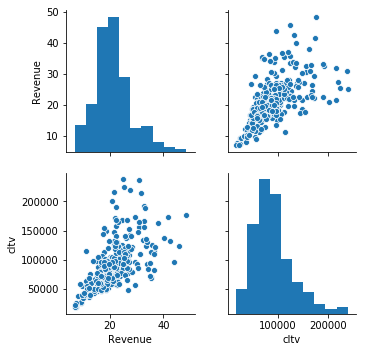

In [24]:
# scatterplots result2
sns.pairplot(result2); 

In [25]:
# get R^2 of model 
X = result2.cltv
Y = result2.Revenue 

model = sm.OLS(Y,X) 
results = model.fit() 
results.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Revenue   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     2585.
Date:                Thu, 07 Nov 2019   Prob (F-statistic):          3.38e-149
Time:                        16:35:56   Log-Likelihood:                -1019.5
No. Observations:                 300   AIC:                             2041.
Df Residuals:                     299   BIC:                             2045.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cltv           0.0002    4.2e-06     50.844      0.000       0.000       0.000
==============================================================================
Omnibus:                       41.888   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.380
Skew:                          -0.663   Prob(JB):                     3.56e-23
Kurtosis:                       5.551   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# get the slope and intercept for regression formula 
x = result2.cltv
y = result2.Revenue 
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

print('y =', round(slope,6),'* x +', round(intercept, 2))

y = 0.000107 * x + 11.5


In [41]:
# regplot cltv & revenue: is avg cltv predictor for avg revenue over time? 
x = result2.cltv
y = result2.Revenue

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
line = slope*x+intercept

# line data (scatter dots)
line1 = go.Scatter(x=x, y=y, mode='markers', marker=go.Marker(color='rgb(93, 151, 201)'), name='Data')

# line fit (regression line)
line2 = go.Scatter(x=x, y=line, mode='lines', marker=go.Marker(color='rgb(235, 120, 179)'), name='Fit')

# text in plot 
annotation = go.Annotation(x=50000, y=48, text='$ R^2 = 0.896, y = 0.000107 * x + 11.54$',
                           showarrow=False,font=go.Font(size=15))

# layout setup 
layout = go.Layout(title='Linear Fit between Customer Lifetime Value & Revenue', 
                   plot_bgcolor='rgb(240, 240, 240)', #achtergrond kleur
                   xaxis=go.XAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'), #lijnen achtergrond
                   yaxis=go.YAxis(zerolinecolor='rgb(255,255,255)', gridcolor='rgb(255,255,255)'), #lijnen achtergrond
                   annotations=[annotation], 
                   xaxis_title="Customer Lifetime Value",
                   yaxis_title="Revenue",) #text 

# plot regression 
data = [line1, line2]
go.Figure(data=data, layout=layout) 

In [28]:
# PREDICTION MODEL CLTV 

In [29]:
# step 1: set Date to index (for empty date, fill in the mean cltv) 
result2.index = pd.DatetimeIndex(result2.Date) 
result3 = result2.reindex(pd.date_range(min(result2.Date),max(result2.Date)), fill_value=(result2['cltv'].mean())) 
result3 = pd.DataFrame(result3['cltv']) 

result3.index 

# I made a df with all the days within the time period of the dataset (date.max, date.min) 
# filled the dates which were empty with mean value of cltv over time (on dates there were no orders for example)
# checked the freq of the index >> in this example, it should be 'D' (days) 

DatetimeIndex(['2010-12-01', '2010-12-02', '2010-12-03', '2010-12-04',
               '2010-12-05', '2010-12-06', '2010-12-07', '2010-12-08',
               '2010-12-09', '2010-12-10',
               ...
               '2011-11-30', '2011-12-01', '2011-12-02', '2011-12-03',
               '2011-12-04', '2011-12-05', '2011-12-06', '2011-12-07',
               '2011-12-08', '2011-12-09'],
              dtype='datetime64[ns]', length=374, freq='D')

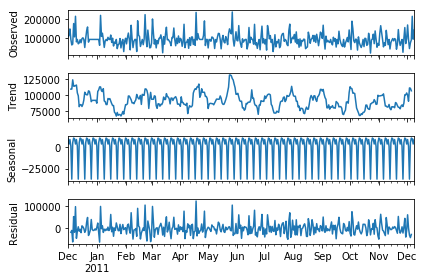

In [30]:
# step 2: decompose the time series and evaluate the patterns in the data
res = sm.tsa.seasonal_decompose(result3.cltv)  
resplot = res.plot() 

# you can see a seasonal trend: probably per week 

In [31]:
# MODDELING THE DATA 

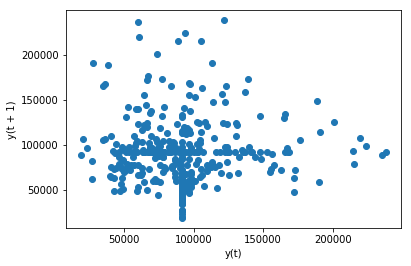

In [32]:
# step 3: check for autocorrelation (line in diagonal = autocorrelation)
lag_plot(result3.cltv); 

# conclusion: there is no diagonal, so if you make a model the fit would not be very good
# but: let's try anyway and check the RMSE score afterwords 

In [33]:
# step 4: check for stationarity (p<0.05 = stationary)
adfuller(result3.cltv)[1] 

# conclusion: stationary 

5.985087544567146e-06

In [34]:
# step 5: ARMA mmodel 
train, test = result3.cltv[:-75], result3.cltv[-75:] # train=80% of total, test=20% of total

model = ARMA(result3.cltv, order=(14,1)) # compare with steps of 14 days = lowest RMSE
model_fit = model.fit(disp=False)

predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False) 

In [35]:
# check RMSE score for prediction 
compare_data = pd.DataFrame({'observed':test, 'predicted':predictions}) # df with test values and prediction values

RMSE = rmse(compare_data.observed, compare_data.predicted) # this nr should be as low as possible, 
                                                        # but it depends on the range of your variable (cltv)
print('RMSE score:', round(RMSE,2), '\nThis is', round((round(RMSE,2)/round(result3.cltv.max(),2))*100), 
      '% of the maximum value of cltv \nConclusion: not a very good prediction model based on this dataset') 

RMSE score: 33856.98 
This is 14.0 % of the maximum value of cltv 
Conclusion: not a very good prediction model based on this dataset


In [36]:
# PRODUCT CATEGORIES: UNIT PRICE CATEGORIES

In [37]:
# copy df 
data5 = data4.copy()

# make column with price categories: very low, low, medium, high, very high 
data5['PriceCategory'] = pd.qcut(data5.UnitPrice, 5, labels=["Very Low", "Low", "Medium", "High", "Very High"])
data5.head() 

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date,Revenue,PriceCategory
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom,2010-12-01,15.30,High
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom,2010-12-01,20.34,High
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom,2010-12-01,22.00,High
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom,2010-12-01,20.34,High
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom,2010-12-01,20.34,High


In [38]:
# Which product type (price category) performs the best (total revenue)? 
data6 = data5.groupby('PriceCategory')['Revenue'].sum().reset_index()

data6.iplot(kind='bar', x='PriceCategory', xTitle='Product Category (Unit Price)', yTitle='Total Revenue', 
           title='Total Revenue by Product Category', color='rgb(235, 120, 179)') 

In [39]:
# Plot revenue by product category by date: which product category performs the best (highest revenue) over time
data7 = data5.pivot_table(values='Revenue', columns='PriceCategory', index='Date', aggfunc='sum').rename(columns=str).reset_index()

data7.iplot(kind='line', x='Date', xTitle='Date', yTitle='Total Revenue', 
            title='Total Revenue by Product Category by Time') 

In [40]:
# Is the total Revenue by category over time significantly different? 
data8 = data7[['Very Low', 'Low', 'Medium', 'High', 'Very High']]
stats.f_oneway(data8['Very Low'], data8['Low'], data8['Medium'], data8['High'], data8['Very High']) # Yes it is 

F_onewayResult(statistic=70.36264898177728, pvalue=1.0147795890582934e-54)